![](https://images.pexels.com/photos/1766838/pexels-photo-1766838.jpeg?auto=compress&cs=tinysrgb&dpr=2&h=750&w=1260)

# Apriltag Camera Calibration

Kevin J. Walchko, Phd

12 July 2020

---

A checkerboard target is one of the best calibration target for a camera. The problem becomes, you need to fit the entire target into the image. This leads to the edges not getting a large sampling and the point *coverage* mainly being in the center of the image (camera FOV).

Once you have a calibrated camera, you can calculate the camera distance to a known target. Here, we will use an apriltag to estimate the camera distance from the tag.

## References

- Rosebrock: [Find distance from camera to object/marker using Python and OpenCV](https://www.pyimagesearch.com/2015/01/19/find-distance-camera-objectmarker-using-python-opencv/)

In [1]:
# reload library
%load_ext autoreload
%autoreload 2

# plotting
%matplotlib inline 

In [2]:
%matplotlib inline
import numpy as np
np.set_printoptions(precision=1)
np.set_printoptions(suppress=True)

from matplotlib import pyplot as plt
import pylab                                 
pylab.rcParams['figure.figsize'] = (10.0, 18.0)

import cv2

import time

from pupil_apriltags import Detector
# import apriltag_gen as apt

import imageio

from glob import glob

In [6]:
from opencv_camera import CameraCalibration
# from opencv_camera import Markers
from opencv_camera import mosaic
from opencv_camera import UnDistort
from opencv_camera import SaveVideo
from opencv_camera.targets.apriltags import ApriltagFinder
import opencv_camera

from collections import namedtuple

DistortionCoefficients = namedtuple("DistortionCoefficients", "k1 k2 p1 p2 k3")

print(f">> opencv_camera version: {opencv_camera.__version__}")

>> opencv_camera version: 0.10.10


In [5]:
def draw_id(img, tags):
    """
    Draws the tag IDs on the found tags
    
    img: single color image
    tags: array of tags found in image
    """
    if len(img.shape) == 2:
        color_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    else:
        color_img = img.copy()

    for tag in tags:
        color_img = draw_tag(color_img, tag.corners, tag.tag_id)
    return color_img

In [7]:
def draw_tag(color_img, corners, tag_id=None):
    """
    color_img: image to draw on, must be color
    corners: corner points from apriltag detector, v[0] is the 
             lower left of the tag and the point move CCW.
    """ 
    pts = corners.reshape((-1,1,2)).astype('int32')
    cv2.polylines(color_img,[pts],True,(0,255,0),thickness=4)

    # r = 15
    y = color_img.shape[0]
    r = max(int(y/200),1)
    c = (255,0,0)
    oc = (0,0,255)
    v = corners.astype('int32')
    cv2.circle(color_img, tuple(v[0]),r,oc,thickness=-1)
    cv2.circle(color_img, tuple(v[1]),r,c,thickness=-1)
    cv2.circle(color_img, tuple(v[2]),r,c,thickness=-1)
    cv2.circle(color_img, tuple(v[3]),r,c,thickness=-1)
    
    if tag_id is not None:
        offset = int((v[1][0]-v[0][0])/4)
        cv2.putText(color_img, str(tag_id),
                    org=(v[0][0]+offset,v[0][1]-offset,),
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=1,
                    thickness=4,
                    color=(255, 0, 255))
    
    return color_img

def draw_imgpts(img, tags):
    if len(img.shape) == 2:
        color_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    else:
        color_img = img.copy()

    for t in tags:
            color_img = draw_tag(color_img, t.corners)
        
    return color_img

In [7]:
class ApriltagCameraCalibrator:
    tag_sizes = {
        'tag16h5' : 6,
        'tag25h9' : 7,
        'tag36h11': 8,
    }
    def __init__(self, detector):
        self.detector = detector
        
    def find_markers(self, images):
        tags = []
        num = 0
        if len(images[0].shape) > 2:
            raise Exception(f"Images must be grayscale, not shape: {images[0].shape}")
            
        for img in images:
            t = self.detector.detect(
                img, 
                estimate_tag_pose=False, 
                camera_params=None, 
                tag_size=0.0235)
            
            tags.append(t)
            num += len(t)

        print(f">> Found {num} points across {len(tags)} images")
        return tags
        
    def calibrate(self, images, marker_size, tag_size):
        """
        images: array of graysccale images
        marker_size: tuple size, ex: (6,9)
        tag_size: size of tag in meters, ex: 0.0235 (or 23.5mm)"""
        tags = self.find_markers(images)
        
        objpts = self.obj_points(marker_size)
        
        # list of tags found by detector for each image
        img_ids = [[t.tag_id for t in f] for f in tags]

        # list of searchable tag coordinates found by detector for each image
        stags = [{t.tag_id: t.corners for t in tag} for tag in tags]

        # points found in image from detector
        imgpoints = []

        # point locations on an ideal target array
        objpoints = []

        for stag,ids,im in zip(stags, img_ids,images):
            op = [] # objpoints
            ip = [] # imgpoints

            # putting the ids in order
            ids.sort()
            #s=0.0235/8 # fixme
            s=tag_size/8 # fixme
            for id in ids:
                for x in objpts[id]:
                    op.append((s*x[0],s*x[1], 0,))

                for x in stag[id]:
                    ip.append(x)
                    
            #criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
            #ip = cv2.cornerSubPix(im, ip, (11, 11), (-1, -1), criteria)
            #img = cv2.drawChessboardCorners(im, (width, height), corners2, True)

            x = np.array(ip, dtype=np.float32)
            imgpoints.append(x)

            x = np.array(op, dtype=np.float32)
            objpoints.append(x)
        
        h,w = imgs[0].shape[:2]
        K = None
        rms, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
            objpoints, imgpoints, (w, h), K, None)

        print(f"RMS error: {rms}")
        print(f"distortion coefficients: {dist}")
        print(f"camera matrix:\n{mtx}")
        
        data = {
            'date': time.strftime("%a, %d %b %Y %H:%M:%S", time.localtime()),
#             'markerType': self.marker_type,
            'markerSize': marker_size,
            'imageSize': images[0].shape,
            'cameraMatrix': mtx,
            'distCoeffs': DistortionCoefficients(*dist[0]),
            'rms': rms,
            'rvecs': rvecs,
            'tvecs': tvecs,
            'imgpoints': imgpoints,
            'objpoints': objpoints
        }
        return data
    
    def obj_points(self, sz, ofw=2):
        ofr = 8+ofw
        ofc = 8+ofw
        r = sz[0]*(ofr)
        c = sz[1]*(ofc)
        b = np.ones((r,c))
        objpts = {}

        for i in range(sz[0]):     # rows
            for j in range(sz[1]): # cols
                r = i*(ofr)+ofw
                c = j*(ofc)+ofw
                x = i*sz[1]+j

                rr = r+8
                cc = c+8
                objpts[x] = ((rr,c),(rr,cc),(r,cc),(r,c)) # ccw - best
        return objpts
    
    def coverage(self, size, imgpoints):
        y,x = size #imgs[0].shape[:2]
        tgt = np.zeros((y,x,3),dtype=np.uint8)

        rad = 5*max(int(y/1000),1)
        c = (0,0,255)
        for f in imgpoints:
            for x in f:
                cv2.circle(tgt, tuple(x.astype(int)),rad,c,thickness=-1)

        return tgt
    
    def board(self, marker_size, scale=10, ofw=2):
        r = marker_size[0]*marker_size[1]
        family = self.detector.params["families"][0]
        tags = apt.generate(family, range(r))

        ofr = 8+ofw
        ofc = 8+ofw
        r = marker_size[0]*(ofr)
        c = marker_size[1]*(ofc)
        b = np.ones((r,c))

        for i in range(marker_size[0]):     # rows
            for j in range(marker_size[1]): # cols
                r = i*(ofr)
                c = j*(ofc)
                x = i*marker_size[1]+j
                tag = tags[x].array
                b[r:r+8,c:c+8] = tag

        # border
        r,c = b.shape
        mm = np.ones((r+ofw, c+ofw), dtype=np.uint8)
        mm[ofw:,ofw:] = b
        mm = 255*mm

        # scale image
        xx = np.repeat(np.repeat(mm, scale, axis=0), scale, axis=1)

        return xx

In [8]:
# create a detector and a camera calibrator
d = Detector(families='tag36h11',
        nthreads=1,
#         quad_decimate=12.0,
        quad_decimate=1.0,
        quad_sigma=0.0,
        refine_edges=1,
        decode_sharpening=0.20,
        debug=0)

# atcc = ApriltagCameraCalibrator(d)
apt

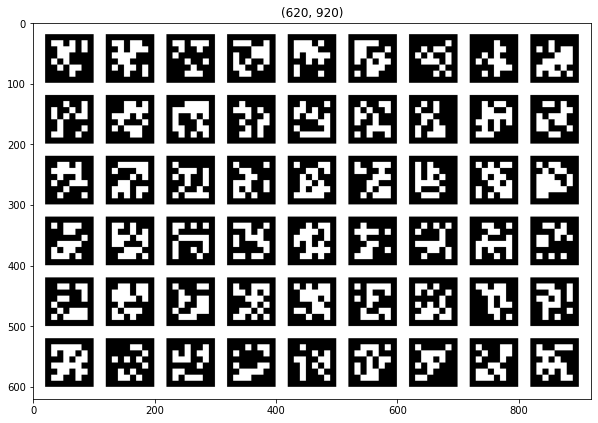

In [9]:
# generate a target board for printing. Make sure to attach it to a
# flat surface. 
from moms_apriltags import board
xx = atcc.board((6,9),10)
plt.imshow(xx, cmap="gray")
plt.title(xx.shape);

In [10]:
# save it
imageio.imwrite("xx.png", xx)

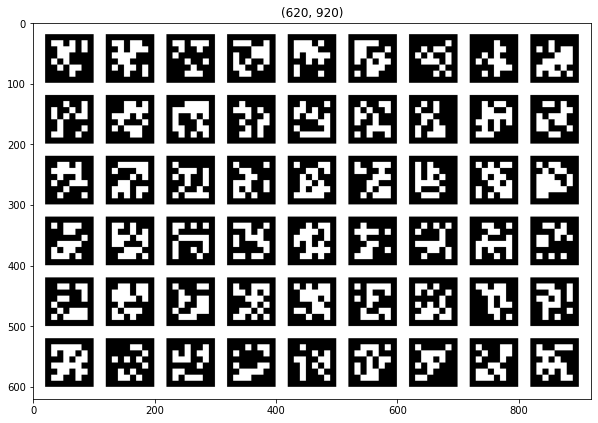

In [11]:
# for giggles, we are going to load it back in and run it through
# the detector to make sure it works
imxx = imageio.imread('xx.png')
plt.imshow(imxx, cmap="gray")
plt.title(imxx.shape);

In [12]:
d = Detector(families='tag36h11',
        nthreads=1,
        quad_decimate=1.0,
        quad_sigma=0.0,
        refine_edges=1,
        decode_sharpening=0.25,
        debug=0)

# k = [fx, fy, cx, cy]
k = [329.8729619143081, 528.0, 332.94611303946357, 396.0]
tags = d.detect(
    imxx, estimate_tag_pose=True, camera_params=k, tag_size=1.0)

# since our target is 6*9, we should get 54 tags found
print(f">> {len(tags)}")

# let's look at one tag ... doesn't matter which one
print(tags[1])

>> 54
Detection object:
tag_family = b'tag36h11'
tag_id = 1
hamming = 0
decision_margin = 120.0
homography = [[ 40.1  -0.5 159.9]
 [  0.   39.9  59.8]
 [  0.   -0.    1. ]]
center = [159.9  59.8]
corners = [[119.8  99.9]
 [199.9  99.8]
 [199.8  19.9]
 [120.1  19.9]]
pose_R = [[ 1.   0.2 -0.1]
 [-0.1  0.9  0.4]
 [ 0.2 -0.4  0.9]]
pose_t = [[-2.3]
 [-2.8]
 [ 4.4]]
pose_err = 0.0018567211775543208



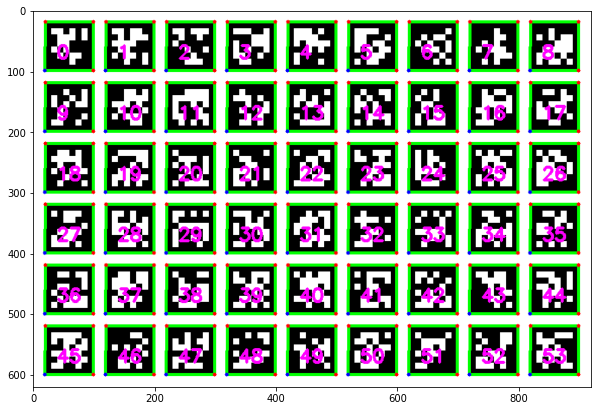

In [13]:
pp = draw_id(imxx, tags)
plt.imshow(pp);

In [14]:
fnames = glob("cals/iphone/png/*.png")
fnames.sort()
print(f"Found {len(fnames)} images")

Found 18 images


In [15]:
imgs = []

for f in fnames:
    im = cv2.imread(f, 0)
    imgs.append(im)
    
print(f"size: {imgs[0].shape}")

size: (3024, 4032)


49


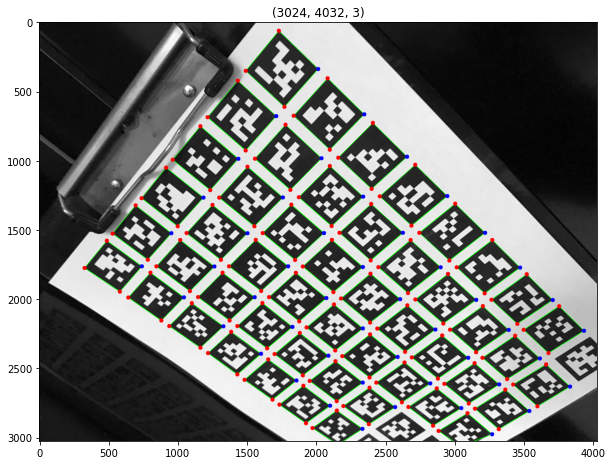

In [16]:
d = Detector(families='tag36h11',
        nthreads=1,
        quad_decimate=12.0,
        quad_sigma=0.0,
        refine_edges=1,
        decode_sharpening=0.20,
        debug=0)

num = 1
img = imgs[num].copy()
tags = d.detect(
    img, estimate_tag_pose=False, camera_params=None, tag_size=0.015)
print(len(tags))

if len(tags) > 0:
    im = draw_imgpts(img, tags)
else:
    im = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
plt.imshow(im)
plt.title(im.shape);

## Calibrate

Each tag in the printed target is 23.5mm or 0.0235m on a side.

In [170]:
data = atcc.calibrate(imgs, (6,9), 0.0235)

>> Found 820 points across 18 images
RMS error: 4.210225967819032
distortion coefficients: [[ 0.1 -0.4  0.  -0.   0.6]]
camera matrix:
[[3373.6    0.  1999.1]
 [   0.  3367.5 1503.2]
 [   0.     0.     1. ]]


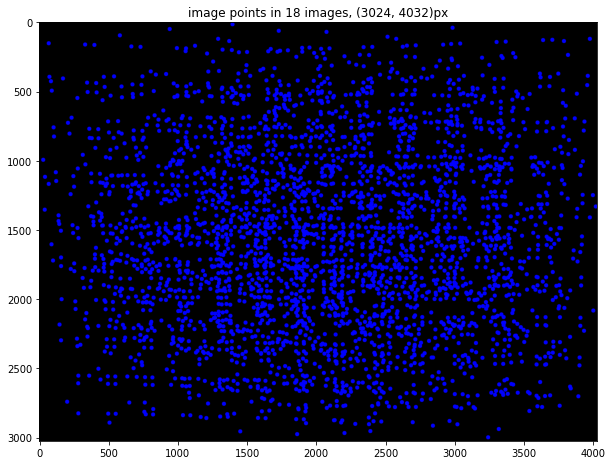

In [171]:
# the focal plane is covered by target corners (shown in blue). Ideally we would
# want all of the black covered, especially around the edegs and corners.
tgt = atcc.coverage(data["imageSize"], data["imgpoints"])
plt.imshow(tgt)
plt.title(f"image points in {len(imgs)} images, {imgs[0].shape}px");

In [23]:
# image = imgs[15]
# better = un.undistort(image,1)

# plt.subplot(1,2,1)
# plt.imshow(image, cmap='gray');
# plt.title('Distorted')

# plt.subplot(1,2,2)
# plt.imshow(better, cmap='gray');
# plt.title('Undistorted');

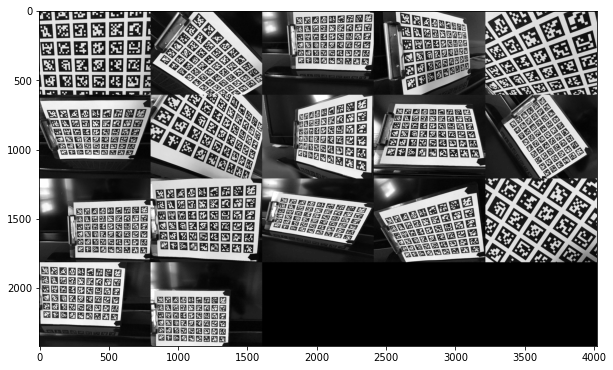

In [24]:
# below is a montage of the input images used in the calibration. 
nn = tip_sheet(imgs)
plt.imshow(nn, cmap="gray");

In [40]:
# https://en.wikipedia.org/wiki/Curve_orientation#Orientation_of_a_simple_polygon
# cw < 0
# ccw > 0
tcw = lambda a,b,c: (b[0]*c[1]+a[0]*b[1]+a[1]*c[0])-(a[1]*b[0]+b[1]*c[0]+a[0]*c[1]) < 0

tcw(*vv[:3])

True

In [41]:
a=vv[:3].copy()
a.reverse()
tcw(*a)

False

# Range to Camera

Given a camera matrix and knowing the width of the object in the real world, we can calculate the camera distance from it.

$$
D_{m} = w_{m}*f_{px}/w_{px}
$$

where $D$ is distance in meters, $f$ is the focal length in the x-direction in pixels, and $w$ is the objects width in either meters or pixels.

The result is pretty close to accuarate, but I didn't test this extensively.

In [165]:
# grab an image
im = imgs[10].copy()

d = Detector(families='tag36h11',
        nthreads=1,
        quad_decimate=12.0,
        quad_sigma=0.0,
        refine_edges=1,
        decode_sharpening=0.20,
        debug=0)

"""
fx is the mtx[0][0] location
array([[3375.2,    0. , 1998.2],
       [   0. , 3368.8, 1501. ],
       [   0. ,    0. ,    1. ]])
"""

K = data["cameraMatrix"]
K = [K[0][0],K[1][1],K[0][2],K[1][2]]

tags = d.detect(
    im, estimate_tag_pose=True, 
    camera_params=K, tag_size=0.0235)

print(f">> Found {len(tags)} tags")

stags = {t.tag_id: t.corners for t in tags}

>> Found 52 tags


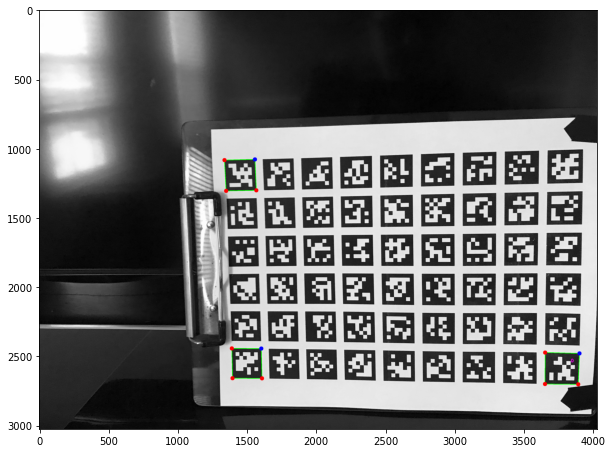

In [166]:
cim = cv2.cvtColor(im, cv2.COLOR_GRAY2BGR)
cim = draw_tag(cim, stags[0], 0)
cim = draw_tag(cim, stags[8])
cim = draw_tag(cim, stags[53])
plt.imshow(cim);

In [164]:
cam_dist = lambda d,f,a,b: d*f/(a - b)

pts = {}
for t in tags:
    if t.tag_id in [0,8,53]:
        pts[t.tag_id] = t.corners

f_x = K[0]

print(f"{cam_dist(0.0235, f_x, pts[0][0][0], pts[0][1][0]):.3f} m")

0.320 m
